# 2D Pose Estimation

In [1]:
%matplotlib inline

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np

## Build the dataset

![Dataset Joints](res/joints.png)

In [2]:
IMG_FOLDER = 'images'
release = loadmat('mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')['RELEASE']

In [12]:
for i in release['annolist'][0,0][0]:
    if i['image']['name'][0,0][0] == '051701472.jpg':
        print(i['annorect'].shape)
        break
#release['annolist'][0,0][0][4]['annorect']['annopoints'].shape

(1, 8)


In [4]:
data = []

# TODO: adapt code to support multi-target
# Code adapted from: https://github.com/mitmul/deeppose/blob/master/datasets/mpii_dataset.py
for i, anno in enumerate(release['annolist'][0, 0][0]):

    img_fn = anno['image']['name'][0, 0][0]
    head_rect = []
    
    if 'x1' in str(anno['annorect'].dtype):
        head_rect = zip(
            [x1[0, 0] for x1 in anno['annorect']['x1'][0]],
            [y1[0, 0] for y1 in anno['annorect']['y1'][0]],
            [x2[0, 0] for x2 in anno['annorect']['x2'][0]],
            [y2[0, 0] for y2 in anno['annorect']['y2'][0]])

    if 'annopoints' in str(anno['annorect'].dtype):
        annopoints = anno['annorect']['annopoints'][0]
        head_x1s = anno['annorect']['x1'][0]
        head_y1s = anno['annorect']['y1'][0]
        head_x2s = anno['annorect']['x2'][0]
        head_y2s = anno['annorect']['y2'][0]
        for annopoint, head_x1, head_y1, head_x2, head_y2 in zip(annopoints, head_x1s, head_y1s, 
                                                                 head_x2s, head_y2s):
            if annopoint != []:
                head_rect = [float(head_x1[0, 0]),
                             float(head_y1[0, 0]),
                             float(head_x2[0, 0]),
                             float(head_y2[0, 0])]

                # joint coordinates
                annopoint = annopoint['point'][0, 0]
                j_id = [j_i[0, 0] for j_i in annopoint['id'][0]]
                x = [x[0, 0] for x in annopoint['x'][0]]
                y = [y[0, 0] for y in annopoint['y'][0]]
                joint_pos = []
                for _, (_x, _y) in sorted(zip(j_id, zip(x, y))):
                    joint_pos.append([float(_x), float(_y)])

                # visiblity list
                if 'is_visible' in str(annopoint.dtype):
                    vis_mask = [v[0] if v else [0]
                           for v in annopoint['is_visible'][0]]
                    vis_mask = [int(v[0]) if len(v) > 0 else v for _, v in sorted(zip(j_id, vis_mask))]
                else:
                    vis_mask = None
                
                if len(joint_pos) == 16:
                    data.append({
                        'filename': img_fn,
                        'head_rect': head_rect,
                        'visibility_mask': vis_mask,
                        'joint_pos': joint_pos
                    })
                    

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


### Split into train-test

__NOTE__: We ignore the default train - test annotations because of examples with missing joint annotations. We first get the complete (full 16 joints) examples, and then perform the train-test split.

In [5]:
train, test = train_test_split(data, test_size=0.1)
del data

### Visualize some train data

In [6]:
joint_unions = [(9, 8), (8, 12), (12, 11), (11, 10), (8, 13), (13, 14), (14, 15), (8, 7), (7, 6), (6, 2), \
                (2, 1), (1, 0), (6, 3), (3, 4), (4, 5)]

# TODO: plot head_rect
def plot_example(data_dict):
    """
    Input:
        - data_dict: dictionary with fields ['filename', 'head_rect', 'visibility_mask', 'joint_pos']
    Output:
        - plot of the image with the joint skeletons drawn above
    """
    img = mpimg.imread(f'{IMG_FOLDER}/{data_dict["filename"]}')
    plt.figure()
    plt.imshow(img)
    
    for o, t in joint_unions:
        if data_dict['visibility_mask'][o] | data_dict['visibility_mask'][t]:
            plt.plot([data_dict['joint_pos'][o][0], data_dict['joint_pos'][t][0]], 
                     [data_dict['joint_pos'][o][1], data_dict['joint_pos'][t][1]])
    
    plt.axis('off')
    

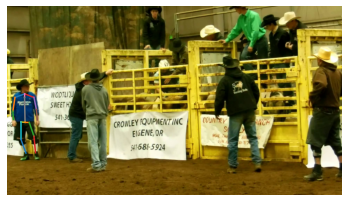

In [10]:
plot_example(train[0])

In [11]:
train[0]['filename']

'051701472.jpg'